In [1]:
#Importing the Nominatim geocoder class 
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
from geopy.extra.rate_limiter import RateLimiter
import urllib
import requests
from geopy.geocoders import GoogleV3
from pulp import *
from numpy import radians, cos, sin, sqrt
from numpy import arcsin as asin
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import re
import operator

import csv
import googlemaps
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# pip install k-means-constrained - It is supported on Python 3.8 and above.
#from k_means_constrained import KMeansConstrained
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as hc
#from fcmeans import FCM
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
#pip install threadpoolctl==3.1.0

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import math

# import the necessary libraries
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
import itertools

In [2]:
data = pd.read_excel(r'C:/Users/leemn/OneDrive/Documents/Route Planning/Takealot_CTD_Data.xlsx',
                   sheet_name='CTD_27_Feb')
data.head()

,waybillid,driverid,Delivery,Timestamp,Delivery_lat,Delivery_lon,Origin_Hub,Origin_Lat,Origin_Long
0,96766835.0,32631.0,2023-02-27,08:03:01.992,-33.966939,18.500546,CTD,-33.862592,18.521128
1,96762597.0,32631.0,2023-02-27,08:11:50.528,-33.978897,18.506432,CTD,-33.862592,18.521128
2,96693569.0,32631.0,2023-02-27,08:55:31.821,-33.998144,18.509564,CTD,-33.862592,18.521128
3,96733983.0,32631.0,2023-02-27,09:10:54.647,-34.014890,18.483872,CTD,-33.862592,18.521128
4,96804265.0,32631.0,2023-02-27,09:27:13.333,-33.998820,18.474928,CTD,-33.862592,18.521128


In [5]:
def optimize_route(nodes):
    order_count = len(nodes)
    restart_iteration = 100

    route_distances_matrix = fetch_distance_matrix_offline(nodes)

    if order_count <= 2:
        print('only 1 order in node')
        return {'route_plan': [0, 1, 2], 'route_distance': 1.1}

    if order_count < 11:
        restart_iteration = 100
    elif 11 <= order_count <= 20:
        restart_iteration = 250
    elif 21 <= order_count <= 40:
        restart_iteration = 800
    elif 41 <= order_count <= 80:
        restart_iteration = 1000
    else:
        restart_iteration = 1000

    temp_start = 1e+10
    temp_end = 0.000001
    cooling_fact = 0.99
    # Firt random route selection (Using index range from 0 to nrows)
    random_generator = np.random.permutation(range(1, len(route_distances_matrix)))
    route_best = np.array(random_generator).tolist()
    route_best.insert(0, 0)
    route_best.append(0)
    distance_best = total_distance(route_best, route_distances_matrix)
    try:
        for restart in range(restart_iteration):
            # restart variables from best known solution (Efficiency update)
            temp = temp_start
            route_current = route_best[:]
            route_new = route_current[:]
            distance_current = distance_best
            distance_new = distance_current
            while temp > temp_end:
                swap_index = random.sample(range(1, len(route_distances_matrix)), 2)
                route_new[swap_index[0]], route_new[swap_index[1]] = route_current[swap_index[1]], route_current[
                    swap_index[0]]
                distance_new = swap_distance(distance_current, route_current, route_distances_matrix, swap_index)
                diff = distance_new - distance_current
                if diff < 0 or math.exp(-diff / temp) > random.random():
                    route_current = route_new[:]
                    distance_current = distance_new
                else:
                    route_new = route_current[:]
                    distance_new = distance_current
                if distance_new < distance_best:
                    route_best = route_new[:]
                    distance_best = distance_new
                temp = temp * cooling_fact

        route = []
        for best in range(0, len(route_best)):
            route.append(route_distances_matrix[route_best[best]])

        return {'route_plan': route_best, 'route_distance': distance_best}

    except KeyboardInterrupt:
        print('Code execution cancelled')

def fetch_distance_matrix_offline(locations):
    amount_of_locations = locations[:]
    distance_matrix = [[] for loc in range(len(amount_of_locations))]

    for index, base_location in enumerate(locations):
        # split_lat_lon = base_location.split(',')
        base_lat = float(base_location.latitude) * 0.01745329251
        base_lon = float(base_location.longitude) * 0.01745329251

        for destination in locations:
            # split_destination_lat_lon = destination.split(',')
            destination_lat = float(destination.latitude) * 0.01745329251
            destination_lon = float(destination.longitude) * 0.01745329251

            distance_between = np.arccos(
                np.sin(base_lat) * np.sin(destination_lat) + np.cos(base_lat) * np.cos(
                    destination_lat) * np.cos(destination_lon - base_lon)) * 6371

            distance_matrix[index].append(distance_between)

    return distance_matrix

def total_distance(route, route_distance):
    total_distance = 0
    for i in range(0, len(route) - 1):
        total_distance = total_distance + route_distance[route[i]][route[i + 1]]
    return total_distance


def swap_distance(distance_current, route_current, route_distance, swap_index):
    min_index = min(swap_index[0], swap_index[1])
    max_index = max(swap_index[0], swap_index[1])

    if min_index == max_index - 1:
        before_swap = route_distance[route_current[min_index - 1]][route_current[min_index]] + \
                      route_distance[route_current[min_index]][route_current[max_index]] + \
                      route_distance[route_current[max_index]][route_current[max_index + 1]]
        after_swap = route_distance[route_current[min_index - 1]][route_current[max_index]] + \
                     route_distance[route_current[max_index]][route_current[min_index]] + \
                     route_distance[route_current[min_index]][route_current[max_index + 1]]

    else:
        before_swap = route_distance[route_current[min_index - 1]][route_current[min_index]] + \
                      route_distance[route_current[min_index]][route_current[min_index + 1]] + \
                      route_distance[route_current[max_index - 1]][route_current[max_index]] + \
                      route_distance[route_current[max_index]][route_current[max_index + 1]]
        after_swap = route_distance[route_current[min_index - 1]][route_current[max_index]] + \
                     route_distance[route_current[max_index]][route_current[min_index + 1]] + \
                     route_distance[route_current[max_index - 1]][route_current[min_index]] + \
                     route_distance[route_current[min_index]][route_current[max_index + 1]]

    distance_new = distance_current - before_swap + after_swap

    return distance_new

In [3]:
df = data[['waybillid','Delivery_lat','Delivery_lon','Origin_Lat','Origin_Long']].tail(5)

### The held-karp algorithm

The Held-Karp algorithm is a dynamic programming algorithm that calculates the optimal solution by breaking the problem into smaller subproblems. It works by computing the shortest path that visits a subset of the cities and ends at a specific city. It then combines these subproblems to compute the shortest path that visits all cities and ends at the starting city. This algorithm guarantees to find the optimal solution, but it can be computationally expensive, especially for large problem sizes.

In [124]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.optimize import linear_sum_assignment
import itertools
import numpy as np
import pandas as pd
import math


def haversine(origin, destination):
    # haversine distance formula
    lat1, lon1 = origin
    lat2, lon2 = destination
    R = 6371  # earth radius in km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance


def calculate_route(df):
    # extract delivery and depot locations
    delivery_locations = df[['Delivery_lat', 'Delivery_lon']].values
    depot_locations = df[['Origin_Lat', 'Origin_Long']].values

    # calculate pairwise distances between delivery locations and depot locations
    dist1 = pdist(delivery_locations, metric=haversine)
    dist2 = pdist(depot_locations, metric=haversine)

    # convert the pairwise distances into a square distance matrix
    dist_matrix1 = squareform(dist1)
    dist_matrix2 = squareform(dist2)

    # find the minimum spanning tree of the distance matrix
    mst1 = minimum_spanning_tree(csr_matrix(dist_matrix1))
    mst2 = minimum_spanning_tree(csr_matrix(dist_matrix2))

    # get the indices of the edges in the minimum spanning tree
    edge_indices1 = mst1.nonzero()
    edge_indices2 = mst2.nonzero()

    # create a list of all the addresses
    all_addresses = [(df.iloc[i]['Delivery_lat'], df.iloc[i]['Delivery_lon']) for i in range(len(df))]

    # create a list of all the depot addresses
    depot_addresses = [(df.iloc[i]['Origin_Lat'], df.iloc[i]['Origin_Long']) for i in range(len(df))]

    # create a list of all the addresses, including depots
    all_addresses_with_depots = depot_addresses + all_addresses

    # calculate the pairwise distances between all the addresses
    dist = pdist(all_addresses_with_depots, metric=haversine)

    # create the distance matrix
    dist_matrix = squareform(dist)

    # set the diagonal to infinity to prevent cycles
    np.fill_diagonal(dist_matrix, np.inf)

    # find the optimal route using the held-karp algorithm
    row_ind, col_ind = linear_sum_assignment(dist_matrix)

    # remove the depots from the optimal route
    indices_without_depots = [i for i in col_ind if i >= len(depot_addresses)]

    # calculate the optimal route and distance
    optimal_route = [all_addresses[i - len(depot_addresses)] for i in col_ind if i >= len(depot_addresses)]
    optimal_distance = dist_matrix[row_ind, col_ind].sum()

    # add the optimal route and distance to the dataframe
    route_seq = []
    distances = []
    current_lat = df.iloc[0]['Origin_Lat']
    current_long = df.iloc[0]['Origin_Long']
    for i in indices_without_depots:
        lat, long = all_addresses[i - len(depot_addresses)]
        distance = dist_matrix[i - len(depot_addresses), col_ind[i]]
        route_seq.append(i - len(depot_addresses) + 1)
        distances.append(distance)
        current_lat = lat
        current_long = long
    df['Sequence_HK'] = route_seq
    df['Distance_HK'] = distances

    return df

In [38]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.optimize import linear_sum_assignment
import itertools
import numpy as np
import pandas as pd
import math


def haversine(origin, destination):
    # haversine distance formula
    lat1, lon1 = origin
    lat2, lon2 = destination
    R = 6371  # earth radius in km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def calculate_route(df):
    # extract delivery and depot locations
    delivery_locations = df[['Delivery_lat', 'Delivery_lon']].values
    depot_locations = df[['Origin_Lat', 'Origin_Long']].values

    # calculate pairwise distances between delivery locations and depot locations
    dist1 = pdist(delivery_locations, metric=haversine)
    dist2 = pdist(depot_locations, metric=haversine)

    # convert the pairwise distances into a square distance matrix
    dist_matrix1 = squareform(dist1)
    dist_matrix2 = squareform(dist2)

    # find the minimum spanning tree of the distance matrix
    mst1 = minimum_spanning_tree(csr_matrix(dist_matrix1))
    mst2 = minimum_spanning_tree(csr_matrix(dist_matrix2))

    # get the indices of the edges in the minimum spanning tree
    edge_indices1 = mst1.nonzero()
    edge_indices2 = mst2.nonzero()

    # create a list of all the addresses
    all_addresses = [(df.iloc[i]['Delivery_lat'], df.iloc[i]['Delivery_lon']) for i in range(len(df))]

    # create a list of all the depot addresses
    depot_addresses = [(df.iloc[i]['Origin_Lat'], df.iloc[i]['Origin_Long']) for i in range(len(df))]

    # create a list of all the addresses, including depots
    all_addresses_with_depots = depot_addresses + all_addresses

    # calculate the pairwise distances between all the addresses
    dist = pdist(all_addresses_with_depots, metric=haversine)

    # create the distance matrix
    dist_matrix = squareform(dist)

    # set the diagonal to infinity to prevent cycles
    np.fill_diagonal(dist_matrix, np.inf)

    # find the optimal route using the held-karp algorithm
    row_ind, col_ind = linear_sum_assignment(dist_matrix)

    # remove the depots from the optimal route
    indices_without_depots = [i for i in col_ind if i >= len(depot_addresses)]

    # calculate the optimal route and distance
    optimal_route = [all_addresses[i - len(depot_addresses)] for i in col_ind if i >= len(depot_addresses)]
    optimal_distance = dist_matrix[row_ind, col_ind].sum()

    # add the optimal route and distance to the dataframe
    route_seq = []
    distances = []
    current_lat = df.iloc[0]['Origin_Lat']
    current_long = df.iloc[0]['Origin_Long']
    for i in indices_without_depots:
        lat, long = all_addresses[i - len(depot_addresses)]
        distance = dist_matrix[i, col_ind[i]]
        route_seq.append(i - len(depot_addresses) + 1)
        distances.append(distance)
        current_lat = lat
        current_long = long
    df['Sequence_HK'] = route_seq
    df['Distance_HK'] = distances


    # create a list to store all routes and their distances
    # create a list to store all routes and their distances
    all_routes = []

    # add the optimal route and distance to the list of all routes
    optimal_route_str = 'Optimal Route'
    all_routes.append((optimal_route_str, optimal_route, optimal_distance))

    # create a list of all possible permutations of the indices without depots
    permutations = list(itertools.permutations(indices_without_depots))

    # calculate the routes and distances for all the permutations
    for i, perm in enumerate(permutations):
        route = [all_addresses[i - len(depot_addresses)] for i in perm]
        distance = 0
        current_lat = df.iloc[0]['Origin_Lat']
        current_long = df.iloc[0]['Origin_Long']

        # calculate the distance for each leg of the route
        for j in range(len(route)):
            lat, long = route[j]
            distance += haversine((current_lat, current_long), (lat, long))
            current_lat = lat
            current_long = long

        # add the distance from the last stop back to the depot
        distance += haversine((current_lat, current_long), (df.iloc[0]['Origin_Lat'], df.iloc[0]['Origin_Long']))

        # add the route and distance to the list of all routes
        route_str = ' -> '.join([str(loc).strip() for loc in route])
        all_routes.append((f"Route {i+1}: {route_str}", distance))

    # sort the list of all routes by distance in ascending order
    #all_routes.sort(key=operator.itemgetter(1))

    # print the optimal route and distance
    optimal_route_index = all_routes.index((optimal_route_str, optimal_route, optimal_distance))
    optimal_route_label = f"Optimal Route {optimal_route_index}"
    print(f"{optimal_route_label}: {optimal_route}")
    print(f"Optimal Distance: {optimal_distance}")

    # print all the routes and distances
    print("All Routes:")
    for i, route in enumerate(all_routes):
        if i == optimal_route_index:
            continue
        print(f"{route[0]}")
        print(f"Distance: {route[1]}")

    return df

In [39]:
df_hk = calculate_route(df)

Optimal Route 0: [(-34.0380344, 18.6712964), (-34.0305459, 18.6705634), (-34.0491902, 18.6977987), (-34.058231, 18.6890245), (-34.0182287, 18.6623022)]
Optimal Distance: 7.3354501652356365
All Routes:
Route 1: (-34.0380344, 18.6712964) -> (-34.0305459, 18.6705634) -> (-34.0491902, 18.6977987) -> (-34.058231, 18.6890245) -> (-34.0182287, 18.6623022)
Distance: 56.04880153035238
Route 2: (-34.0380344, 18.6712964) -> (-34.0305459, 18.6705634) -> (-34.0491902, 18.6977987) -> (-34.0182287, 18.6623022) -> (-34.058231, 18.6890245)
Distance: 64.55125823747818
Route 3: (-34.0380344, 18.6712964) -> (-34.0305459, 18.6705634) -> (-34.058231, 18.6890245) -> (-34.0491902, 18.6977987) -> (-34.0182287, 18.6623022)
Distance: 55.97558802075411
Route 4: (-34.0380344, 18.6712964) -> (-34.0305459, 18.6705634) -> (-34.058231, 18.6890245) -> (-34.0182287, 18.6623022) -> (-34.0491902, 18.6977987)
Distance: 64.4933503139726
Route 5: (-34.0380344, 18.6712964) -> (-34.0305459, 18.6705634) -> (-34.0182287, 18.6623

In [40]:
df_hk.head(20)

,waybillid,Delivery_lat,Delivery_lon,Origin_Lat,Origin_Long,Sequence_HK,Distance_HK
1374,96265194.0,-34.030546,18.670563,-33.862592,18.521128,5,2.353103
1375,96528038.0,-34.018229,18.662302,-33.862592,18.521128,1,0.835418
1376,96693063.0,-34.058231,18.689024,-33.862592,18.521128,4,1.289968
1377,96755976.0,-34.049190,18.697799,-33.862592,18.521128,3,1.289968
1378,96719582.0,-34.038034,18.671296,-33.862592,18.521128,2,1.566993


Distance: 7.3354501652356365


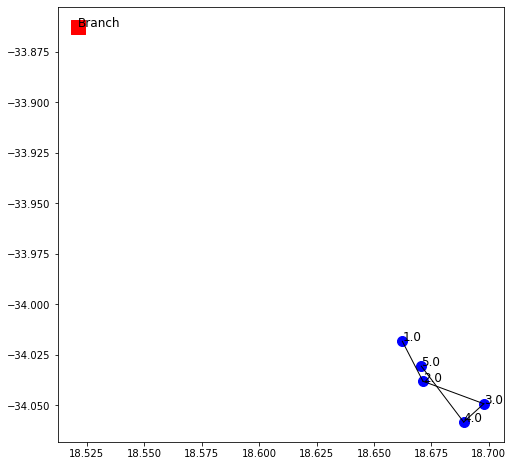

In [42]:
# add branch point
depot_lat = -33.86259
depot_lon = 18.52113

# sort dataframe by sequence
df_hk = df_hk.sort_values('Sequence_HK')

# plot points and labels
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_hk['Delivery_lon'], df_hk['Delivery_lat'], s=100, color='blue')
for i, row in df_hk.iterrows():
    ax.annotate(row['Sequence_HK'], (row['Delivery_lon'], row['Delivery_lat']), fontsize=12)

# plot lines connecting points
for i in range(len(df_hk)-1):
    start = (df_hk.iloc[i]['Delivery_lon'], df_hk.iloc[i]['Delivery_lat'])
    end = (df_hk.iloc[i+1]['Delivery_lon'], df_hk.iloc[i+1]['Delivery_lat'])
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=1)

# plot Branch point
ax.scatter(depot_lon, depot_lat, s=200, color='red', marker='s')
ax.annotate('Branch', (depot_lon, depot_lat), fontsize=12)
print(f'Distance: {df_hk.Distance_HK.sum()}')
plt.show()

### Nearest Neibhor

In [106]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the Haversine distance between two points on the Earth's surface
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

def nearest_neighbor(df, max_iterations=2000):
    # Initialize the route with the depot as the starting point
    df = df.reset_index(drop=True)
    depot_coord = [df.loc[0, 'Origin_Lat'], df.loc[0,'Origin_Long']]
    route = [df.index[0]]
    unvisited = np.ones(len(df), dtype=bool)
    unvisited[0] = False

    # Loop through unvisited orders and add them to the route in the nearest order
    num_iterations = 0
    while unvisited.sum() > 0 and num_iterations < max_iterations:
        # Get the coordinates of the last visited order
        last_order_coord = df.loc[route[-1], ['Delivery_lat', 'Delivery_lon']].astype(float).values

        # Get all unvisited orders with the same coordinates
        same_coord_orders = df.loc[unvisited & (df[['Delivery_lat', 'Delivery_lon']].astype(float).values == last_order_coord).all(axis=1)]

        # If there are any unvisited orders with the same coordinates, group them first
        if len(same_coord_orders) > 0:
            route += list(same_coord_orders.index)
            unvisited[same_coord_orders.index] = False

        # Otherwise, add the nearest unvisited order to the route
        else:
            distances = [haversine(df.loc[route[-1], 'Delivery_lon'], df.loc[route[-1], 'Delivery_lat'], 
                                   df.loc[i, 'Delivery_lon'], df.loc[i, 'Delivery_lat']) for i in df.index[unvisited]]
            nearest_index = np.argmin(distances)
            nearest_order = df.index[unvisited][nearest_index]
            route.append(nearest_order)
            unvisited[nearest_order] = False

        num_iterations += 1

    # Add 'Sequence' column to the dataframe
    df['Sequence_NN'] = np.arange(len(df))+1

    # Calculate distances between consecutive orders in the optimized route
    distances = []
    for i in range(len(route)-1):
        start = df.loc[route[i], ['Delivery_lat', 'Delivery_lon']].astype(float)
        end = df.loc[route[i+1], ['Delivery_lat', 'Delivery_lon']].astype(float)
        distances.append(haversine(start[1], start[0], end[1], end[0]))

    # Add 'Distance' column to the dataframe
    df.loc[route[:-1], 'Distance_NN'] = distances
    df.loc[route[-1], 'Distance_NN'] = 0

    # Reorder the rows in the dataframe according to the optimized route
    df = df.loc[route]

    print(f'Number of iterations: {num_iterations}')

    return df

In [107]:
optimized_df = nearest_neighbor(df)
optimized_df.head()

Number of iterations: 14


,waybillid,Delivery_lat,Delivery_lon,Origin_Lat,Origin_Long,Sequence_HK,Distance_HK,Sequence_NN,Distance_NN
0,96664828.0,-34.040773,18.655868,-33.862592,18.521128,8,0.227814,1,0.257941
7,96781532.0,-34.039792,18.658407,-33.862592,18.521128,2,0.223391,8,0.406758
1,96719860.0,-34.043220,18.659956,-33.862592,18.521128,1,0.224154,2,0.345599
6,96570960.0,-34.044411,18.656488,-33.862592,18.521128,6,0.226672,7,0.408592
5,96588161.0,-34.048059,18.655933,-33.862592,18.521128,7,0.229282,6,1.600483


Distance: 31.21674202388865


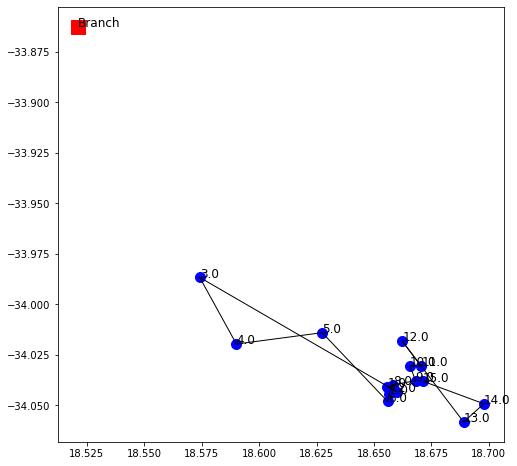

In [109]:
# add branch point
depot_lat = -33.86259
depot_lon = 18.52113

# sort dataframe by sequence
optimized_df = optimized_df.sort_values('Sequence_NN')

# plot points and labels
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(optimized_df['Delivery_lon'], optimized_df['Delivery_lat'], s=100, color='blue')
for i, row in optimized_df.iterrows():
    ax.annotate(row['Sequence_NN'], (row['Delivery_lon'], row['Delivery_lat']), fontsize=12)

# plot lines connecting points
for i in range(len(optimized_df)-1):
    start = (optimized_df.iloc[i]['Delivery_lon'], optimized_df.iloc[i]['Delivery_lat'])
    end = (optimized_df.iloc[i+1]['Delivery_lon'], optimized_df.iloc[i+1]['Delivery_lat'])
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=1)

# plot Branch point
ax.scatter(depot_lon, depot_lat, s=200, color='red', marker='s')
ax.annotate('Branch', (depot_lon, depot_lat), fontsize=12)
print(f'Distance: {optimized_df.Distance_NN.sum()}')
plt.show()